In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv


In [6]:
import pandas as pd
import numpy as np

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.tools as tls
import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode


from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix


import warnings
warnings.filterwarnings('ignore')

In [7]:
df = pd.read_csv('/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv')
df.head()

person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                           3  
1                 0.10                         N                           2  
2                 0.57                         N                           3  
3                 0.53                         N                           2  
4                 0.55                         Y                           4

In [8]:
df.describe()

person_age  person_income  person_emp_length     loan_amnt  \
count  32581.000000   3.258100e+04       31686.000000  32581.000000   
mean      27.734600   6.607485e+04           4.789686   9589.371106   
std        6.348078   6.198312e+04           4.142630   6322.086646   
min       20.000000   4.000000e+03           0.000000    500.000000   
25%       23.000000   3.850000e+04           2.000000   5000.000000   
50%       26.000000   5.500000e+04           4.000000   8000.000000   
75%       30.000000   7.920000e+04           7.000000  12200.000000   
max      144.000000   6.000000e+06         123.000000  35000.000000   

       loan_int_rate   loan_status  loan_percent_income  \
count   29465.000000  32581.000000         32581.000000   
mean       11.011695      0.218164             0.170203   
std         3.240459      0.413006             0.106782   
min         5.420000      0.000000             0.000000   
25%         7.900000      0.000000             0.090000   
50%        10.990000      0.000000             0.150000   
75%        13.470000      0.000000             0.230000   
max        23.220000      1.000000             0.830000   

       cb_person_cred_hist_length  
count                32581.000000  
mean                     5.804211  
std                      4.055001  
min                      2.000000  
25%                      3.000000  
50%                      4.000000  
75%                      8.000000  
max                     30.000000

***
Percentage of nulls in the features
***

In [9]:
round(df.isna().sum()*100/df.shape[0],2)

person_age                    0.00
person_income                 0.00
person_home_ownership         0.00
person_emp_length             2.75
loan_intent                   0.00
loan_grade                    0.00
loan_amnt                     0.00
loan_int_rate                 9.56
loan_status                   0.00
loan_percent_income           0.00
cb_person_default_on_file     0.00
cb_person_cred_hist_length    0.00
dtype: float64

we will plot the missing featurres to know if it should be replaced or dropped

In [10]:
round(df['loan_status'].value_counts()*100/df.shape[0],1)\
# Loan status (0 is non default 1 is default)

loan_status
0    78.2
1    21.8
Name: count, dtype: float64

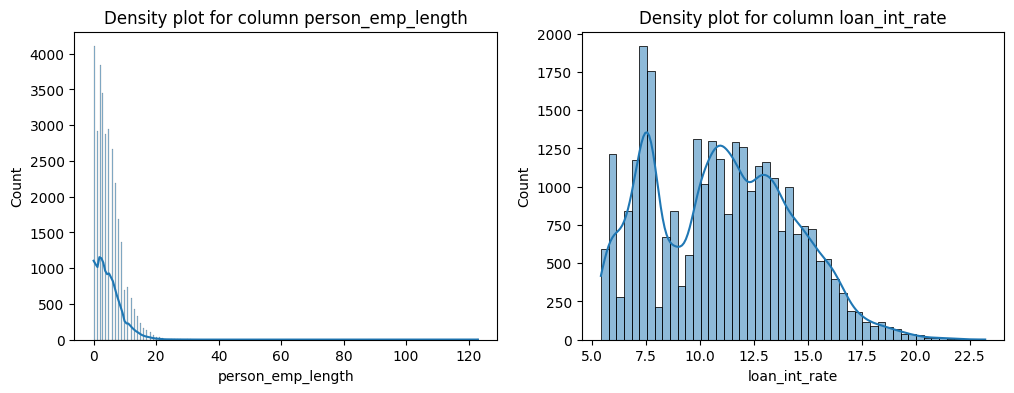

In [11]:
# subplots
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
axes = axes.flatten()

for i, col in enumerate(['person_emp_length','loan_int_rate']):
    sns.histplot(df[col],kde=True, ax=axes[i])
    axes[i].set_title(f'Density plot for column {col}')
plt.show()

***
Take the Categorical and Numerical features in list based on unique values
***

In [12]:
cat_col = []
num_col = []
for i in df.columns:
    print('Uniques in column ', i, ' are ' ,df[i].nunique())
    if df[i].nunique() < 10:
        cat_col.append(i)
    else:
        num_col.append(i)        

Uniques in column  person_age  are  58
Uniques in column  person_income  are  4295
Uniques in column  person_home_ownership  are  4
Uniques in column  person_emp_length  are  36
Uniques in column  loan_intent  are  6
Uniques in column  loan_grade  are  7
Uniques in column  loan_amnt  are  753
Uniques in column  loan_int_rate  are  348
Uniques in column  loan_status  are  2
Uniques in column  loan_percent_income  are  77
Uniques in column  cb_person_default_on_file  are  2
Uniques in column  cb_person_cred_hist_length  are  29


**Correlation**

In [13]:
df.drop(cat_col,axis=1).corr()

person_age  person_income  person_emp_length  \
person_age                    1.000000       0.173202           0.163106   
person_income                 0.173202       1.000000           0.134268   
person_emp_length             0.163106       0.134268           1.000000   
loan_amnt                     0.050787       0.266820           0.113082   
loan_int_rate                 0.012580       0.000792          -0.056405   
loan_percent_income          -0.042411      -0.254471          -0.054111   
cb_person_cred_hist_length    0.859133       0.117987           0.144699   

                            loan_amnt  loan_int_rate  loan_percent_income  \
person_age                   0.050787       0.012580            -0.042411   
person_income                0.266820       0.000792            -0.254471   
person_emp_length            0.113082      -0.056405            -0.054111   
loan_amnt                    1.000000       0.146813             0.572612   
loan_int_rate                0.146813       1.000000             0.120314   
loan_percent_income          0.572612       0.120314             1.000000   
cb_person_cred_hist_length   0.041967       0.016696            -0.031690   

                            cb_person_cred_hist_length  
person_age                                    0.859133  
person_income                                 0.117987  
person_emp_length                             0.144699  
loan_amnt                                     0.041967  
loan_int_rate                                 0.016696  
loan_percent_income                          -0.031690  
cb_person_cred_hist_length                    1.000000

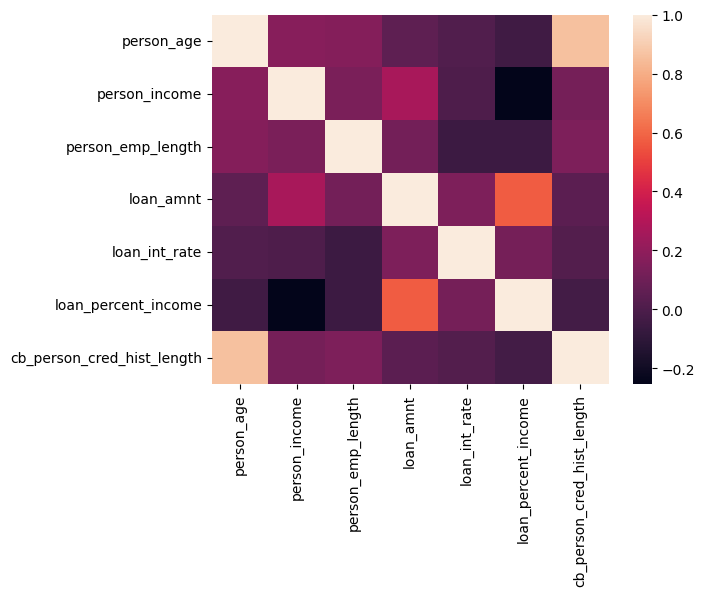

In [14]:
sns.heatmap(df.drop(cat_col,axis=1).corr())
plt.show()

No coreelation is so high that we can remove anmy feature based on that

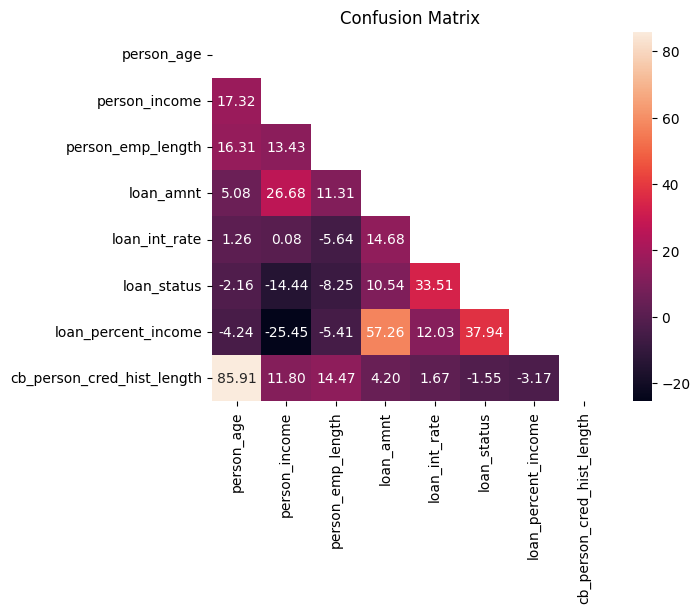

['cb_person_cred_hist_length']

In [15]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    # Select only the numeric columns from the DataFrame
    numeric_dataframe = dataframe.select_dtypes(include=['number'])
    
    corr = numeric_dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    
    if plot:
        mask = np.zeros_like(corr)
        mask[np.triu_indices_from(mask)] = True
        sns.heatmap(corr * 100, annot= True, fmt='.2f', mask=mask)
        plt.title('Confusion Matrix')
        plt.show()
    
    return drop_list

# Usage example:
high_correlated_cols(df, plot=True)

***
Relation between categorical and other features

**Note:**
***
Point Biserial Correlation is only used if there are 2 categories for more than 2 categories go with ANOVA test
***

In [16]:
# Correlation betweeen numeric and categorical features
# Perform ANOVA
for cat in cat_col:
    for num in num_col:
        model = ols(f'{num} ~ C({cat})', data=df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        print(f'Relation with {num} \n{anova_table}')

Relation with person_age 
                                sum_sq       df          F        PR(>F)
C(person_home_ownership)  1.501019e+03      3.0  12.429031  4.041404e-08
Residual                  1.311411e+06  32577.0        NaN           NaN
Relation with person_income 
                                sum_sq       df           F         PR(>F)
C(person_home_ownership)  5.250808e+12      3.0  475.477233  2.060764e-302
Residual                  1.199185e+14  32577.0         NaN            NaN
Relation with person_emp_length 
                                 sum_sq       df           F  PR(>F)
C(person_home_ownership)   30370.958281      3.0  624.747505     0.0
Residual                  513387.511201  31682.0         NaN     NaN
Relation with loan_amnt 
                                sum_sq       df          F         PR(>F)
C(person_home_ownership)  2.278392e+10      3.0  193.38029  2.589453e-124
Residual                  1.279399e+12  32577.0        NaN            NaN
Relation with 

**Note:***
***
p-value less than 0.05 shows that there is a significant difference between the mean of two groups and hence no corelation between the two features.

**Value Counts**

In [17]:
for i in cat_col:
    print(f'Value counts for column {i} is {df[i].value_counts()*100/df.shape[0]}')

Value counts for column person_home_ownership is person_home_ownership
RENT        50.477272
MORTGAGE    41.263313
OWN          7.931003
OTHER        0.328412
Name: count, dtype: float64
Value counts for column loan_intent is loan_intent
EDUCATION            19.806022
MEDICAL              18.633559
VENTURE              17.553175
PERSONAL             16.945459
DEBTCONSOLIDATION    15.997053
HOMEIMPROVEMENT      11.064731
Name: count, dtype: float64
Value counts for column loan_grade is loan_grade
A    33.077561
B    32.076977
C    19.821368
D    11.129186
E     2.958780
F     0.739695
G     0.196434
Name: count, dtype: float64
Value counts for column loan_status is loan_status
0    78.183604
1    21.816396
Name: count, dtype: float64
Value counts for column cb_person_default_on_file is cb_person_default_on_file
N    82.367024
Y    17.632976
Name: count, dtype: float64


In [18]:
df.dropna(inplace=True)
df.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

**Box plots**

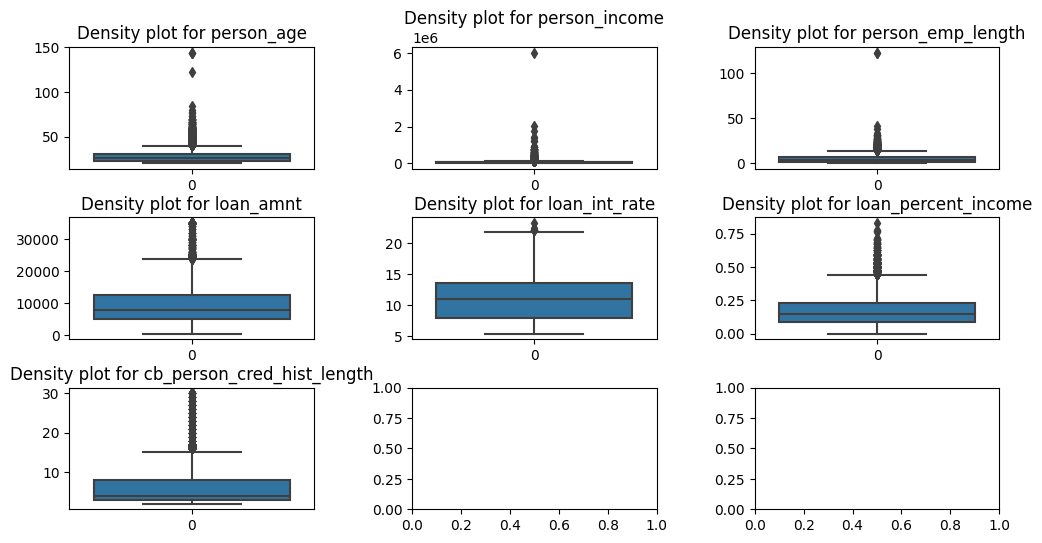

In [19]:
fig, axes = plt.subplots(ncols=3,nrows=3,figsize=(12,6))
axes = axes.flatten()

for index, col in enumerate(num_col):
    sns.boxplot(df[col],ax=axes[index],)
    axes[index].set_title(f'Density plot for {col}')
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

In [20]:
trace0 = go.Bar(x = df[df["loan_status"]== 1]["person_home_ownership"].value_counts().index.values,
    y = df[df["loan_status"]== 1]["person_home_ownership"].value_counts().values,name='Loan status = 1')

#Second plot
trace1 = go.Bar(x = df[df["loan_status"]== 0]["person_home_ownership"].value_counts().index.values,
    y = df[df["loan_status"]== 0]["person_home_ownership"].value_counts().values,name="Loan status = 0")

data = [trace0, trace1]

layout = go.Layout(  title='Housing Distribuition')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Housing-Grouped')

In [21]:

trace0 = go.Bar(x = df[df["loan_status"]== 1]["loan_grade"].value_counts().index.values,
    y = df[df["loan_status"]== 1]["loan_grade"].value_counts().values,name='Loan status = 1')

#Second plot
trace1 = go.Bar(x = df[df["loan_status"]== 0]["loan_grade"].value_counts().index.values,
    y = df[df["loan_status"]== 0]["loan_grade"].value_counts().values,name="Loan status = 0")

data = [trace0, trace1]

layout = go.Layout(  title='Loan Grade Distribuition')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Loan grade')

In [22]:
trace0 = go.Bar(x = df[df["loan_status"]== 1]["loan_intent"].value_counts().index.values,
    y = df[df["loan_status"]== 1]["loan_intent"].value_counts().values,name='Loan status = 1')

#Second plot
trace1 = go.Bar(x = df[df["loan_status"]== 0]["loan_intent"].value_counts().index.values,
    y = df[df["loan_status"]== 0]["loan_intent"].value_counts().values,name="Loan status = 0")

data = [trace0, trace1]

layout = go.Layout(  title='Loan Intent Distribuition')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Loan Intent')

**Modeling:**
***
    * Encoding: Categorical to One Hot or Label
    * Scaling: Stnd Scaling Min Max scaler
    * Sampling: Over Sampling(Smote etc)
    * Spliting: Train-Test and K flod Cross Validation
    * Train: Train on all the models linear, non linear, tree based, distance based, bagging and boosting algos
    * Hyper Parameter Tuning: Tune for all the models and select the best one
    * Auto ML: Use Auto ML tools
    * Train: Train using Deep learning
***

In [23]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [24]:
X = df.drop('loan_status',axis=1, inplace=False)
y = df['loan_status']
print(X.shape,y.shape)

(28638, 11) (28638,)


In [25]:
cat_col.remove('loan_status')

In [26]:
numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [("OneHotEncoder", oh_transformer, cat_col),("StandardScaler", numeric_transformer, num_col)])

In [27]:
X = preprocessor.fit_transform(X)
X.shape

(28638, 26)

Stratify K Fold Sampling then Over Sampling on the Training data
* So that ratio is maintained in the testing part and we can test on every class 
* also there is no shortage of minority class in the training data
* Finally K fold to avoid overfitting

***
**Splitng data, training and results formation**
***

In [28]:
from sklearn.linear_model import LogisticRegression, Lasso, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [29]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVM': SVC(),
    "K-Neighbors Regressor": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest Regressor": RandomForestClassifier(),
    "XGB": XGBClassifier(), 
    "CatBoosting Regressor": CatBoostClassifier(),
    "AdaBoost Regressor": AdaBoostClassifier()
}

In [30]:
type(models['SVM'])

sklearn.svm._classes.SVC

In [31]:
skf = StratifiedKFold(n_splits=5)  # You can choose the number of folds
skf

# Loop through each fold
for train_index, val_index in skf.split(X, y):       
    if isinstance(X, pd.DataFrame):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    else:
        X_train, X_val = X[train_index], X[val_index]

    if isinstance(y, pd.Series):
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    else:
        y_train, y_val = y[train_index], y[val_index]
        
# Apply SMOTE to the training data
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [32]:
def evaluate_models(X_resampled,X_val,y_resampled,y_val,models):
    
    '''Takes X_train,X_val,y_train,y_val and models to be trained and returns the results tested on all the models and for all the cross folds'''
    
    # Initialize dictionary to store results
    results = {model_name: {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'confusion_matrix': []} 
               for model_name in models.keys()}

    # Train and evaluate each model
    for model_name, model in models.items():
        model.fit(X_resampled, y_resampled)
        y_pred = model.predict(X_val)

        # Calculate metrics
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        conf_matrix = confusion_matrix(y_val,y_pred)

        # Append metrics to the results dictionary
        results[model_name]['accuracy'].append(accuracy)
        results[model_name]['precision'].append(precision)
        results[model_name]['recall'].append(recall)
        results[model_name]['f1'].append(f1)
        results[model_name]['confusion_matrix'].append(conf_matrix)
    
    # Calculate average metrics for each model
    average_results = {model_name: {metric: np.mean(scores) 
                                    for metric, scores in metrics.items()} 
                       for model_name, metrics in results.items()}
    
    return average_results

In [33]:
# Caliing the Train function
average_results = evaluate_models(X_train,X_val,y_train,y_val,models)
# print(average_results)

Learning rate set to 0.039235
0:	learn: 0.6513952	total: 61.7ms	remaining: 1m 1s
1:	learn: 0.6145276	total: 68.2ms	remaining: 34s
2:	learn: 0.5833732	total: 75ms	remaining: 24.9s
3:	learn: 0.5532354	total: 81.8ms	remaining: 20.4s
4:	learn: 0.5254900	total: 88.6ms	remaining: 17.6s
5:	learn: 0.4993284	total: 95.9ms	remaining: 15.9s
6:	learn: 0.4796090	total: 103ms	remaining: 14.6s
7:	learn: 0.4624792	total: 110ms	remaining: 13.6s
8:	learn: 0.4437719	total: 116ms	remaining: 12.8s
9:	learn: 0.4304658	total: 123ms	remaining: 12.2s
10:	learn: 0.4174106	total: 129ms	remaining: 11.6s
11:	learn: 0.4041321	total: 136ms	remaining: 11.2s
12:	learn: 0.3929111	total: 143ms	remaining: 10.8s
13:	learn: 0.3837016	total: 149ms	remaining: 10.5s
14:	learn: 0.3741160	total: 156ms	remaining: 10.2s
15:	learn: 0.3657026	total: 163ms	remaining: 10s
16:	learn: 0.3569362	total: 169ms	remaining: 9.8s
17:	learn: 0.3497141	total: 176ms	remaining: 9.59s
18:	learn: 0.3437004	total: 182ms	remaining: 9.41s
19:	learn: 0

In [34]:
print(average_results)

{'LogisticRegression': {'accuracy': 0.8533263488737559, 'precision': 0.8144654088050315, 'recall': 0.41774193548387095, 'f1': 0.5522388059701492, 'confusion_matrix': 1431.75}, 'SVM': {'accuracy': 0.8980268901693731, 'precision': 0.9493150684931507, 'recall': 0.5588709677419355, 'f1': 0.7035532994923858, 'confusion_matrix': 1431.75}, 'K-Neighbors Regressor': {'accuracy': 0.8802165182469006, 'precision': 0.8488664987405542, 'recall': 0.5435483870967742, 'f1': 0.6627335299901672, 'confusion_matrix': 1431.75}, 'Decision Tree': {'accuracy': 0.8819626331412607, 'precision': 0.7113943028485757, 'recall': 0.7653225806451613, 'f1': 0.7373737373737375, 'confusion_matrix': 1431.75}, 'Random Forest Regressor': {'accuracy': 0.9334730225248822, 'precision': 0.9683751363140676, 'recall': 0.7161290322580646, 'f1': 0.8233657858136301, 'confusion_matrix': 1431.75}, 'XGB': {'accuracy': 0.9327745765671381, 'precision': 0.9572192513368984, 'recall': 0.7217741935483871, 'f1': 0.8229885057471263, 'confusion_

In [35]:
# Convert to pandas DataFrame
df_results = pd.DataFrame.from_dict(average_results, orient='index')
df_results

accuracy  precision    recall        f1  \
LogisticRegression       0.853326   0.814465  0.417742  0.552239   
SVM                      0.898027   0.949315  0.558871  0.703553   
K-Neighbors Regressor    0.880217   0.848866  0.543548  0.662734   
Decision Tree            0.881963   0.711394  0.765323  0.737374   
Random Forest Regressor  0.933473   0.968375  0.716129  0.823366   
XGB                      0.932775   0.957219  0.721774  0.822989   
CatBoosting Regressor    0.935219   0.977998  0.716935  0.827362   
AdaBoost Regressor       0.877947   0.822408  0.556452  0.663781   

                         confusion_matrix  
LogisticRegression                1431.75  
SVM                               1431.75  
K-Neighbors Regressor             1431.75  
Decision Tree                     1431.75  
Random Forest Regressor           1431.75  
XGB                               1431.75  
CatBoosting Regressor             1431.75  
AdaBoost Regressor                1431.75

In [36]:
models['CatBoosting Regressor']

***Hyperparameter Tuning***
***
Now we will hyperparameter tune Random Forest Regressor, XGB, CatBoosting Regressor

In [37]:
# Tuning Random Forest

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid_search = GridSearchCV(estimator=models['Random Forest Regressor'] , param_grid=rf_param_grid, cv=3, n_jobs=-1, verbose=0)
rf_grid_search.fit(X_resampled, y_resampled)
print(f"Best parameters for Random Forest: {rf_grid_search.best_params_}")
best_rf = rf_grid_search.best_estimator_

Best parameters for Random Forest: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [38]:
best_rf

RandomForestClassifier(max_depth=30)

In [39]:
# Tuning XGBoost

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9]
}
xgb_grid_search = GridSearchCV(estimator=models['XGB'] , param_grid=xgb_param_grid, cv=3, n_jobs=-1, verbose=0)
xgb_grid_search.fit(X_resampled, y_resampled)
print(f"Best parameters for XGBoost: {xgb_grid_search.best_params_}")
best_xgb = xgb_grid_search.best_estimator_

Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.9}


In [40]:
type(best_xgb)

xgboost.sklearn.XGBClassifier

In [41]:
best_xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [42]:
# Tuning Catboost

catboost_param_grid = {
    'iterations': [500, 1000],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2]
}
catboost_grid_search = GridSearchCV(estimator=models['CatBoosting Regressor'] , param_grid=catboost_param_grid, cv=3, n_jobs=-1, verbose=0)
catboost_grid_search.fit(X_resampled, y_resampled)
print(f"Best parameters for CatBoost: {catboost_grid_search.best_params_}")
best_catboost = catboost_grid_search.best_estimator_

0:	learn: 0.6835226	total: 60.5ms	remaining: 30.2s
1:	learn: 0.6780077	total: 67.2ms	remaining: 16.7s
2:	learn: 0.6695014	total: 73.6ms	remaining: 12.2s
3:	learn: 0.6608735	total: 108ms	remaining: 13.4s
4:	learn: 0.6526953	total: 151ms	remaining: 15s
5:	learn: 0.6449290	total: 196ms	remaining: 16.2s
6:	learn: 0.6402472	total: 248ms	remaining: 17.5s
7:	learn: 0.6330856	total: 289ms	remaining: 17.8s
8:	learn: 0.6260137	total: 331ms	remaining: 18.1s
9:	learn: 0.6212122	total: 376ms	remaining: 18.4s
10:	learn: 0.6168132	total: 417ms	remaining: 18.5s
11:	learn: 0.6132154	total: 495ms	remaining: 20.1s
12:	learn: 0.6068783	total: 561ms	remaining: 21s
13:	learn: 0.6009184	total: 585ms	remaining: 20.3s
14:	learn: 0.5976863	total: 612ms	remaining: 19.8s
15:	learn: 0.5920736	total: 636ms	remaining: 19.2s
16:	learn: 0.5882319	total: 664ms	remaining: 18.9s
17:	learn: 0.5854268	total: 685ms	remaining: 18.4s
18:	learn: 0.5823732	total: 704ms	remaining: 17.8s
19:	learn: 0.5791911	total: 720ms	remainin

In [43]:
best_catboost=catboost_grid_search.best_estimator_
print(best_catboost)

#### Evaluate the Hyperparameter Tuned Models

In [44]:
hyper_models = {    "Random Forest Regressor Tuned": best_rf,"XGB Tuned": best_xgb, 
    "CatBoosting Regressor Tuned": best_catboost}

In [45]:
def evaluate_hyper_models(X_val,y_val,hyper_models):
    
    '''Takes X_val,y_val and tuned models to be evaluted and returns the results tested on all the models'''
    
    # Initialize dictionary to store results
    results = {model_name: {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'confusion_matrix': []} 
               for model_name in hyper_models.keys()}

    # Evaluate each model
    for model_name, model in hyper_models.items():
#         model.fit(X_resampled, y_resampled)
        y_pred = model.predict(X_val)

        # Calculate metrics
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        conf_matrix = confusion_matrix(y_val,y_pred)

        # Append metrics to the results dictionary
        results[model_name]['accuracy'].append(accuracy)
        results[model_name]['precision'].append(precision)
        results[model_name]['recall'].append(recall)
        results[model_name]['f1'].append(f1)
        results[model_name]['confusion_matrix'].append(conf_matrix)
    
    # Calculate average metrics for each model
    average_results_tuned = {model_name: {metric: np.mean(scores) 
                                    for metric, scores in metrics.items()} 
                       for model_name, metrics in results.items()}
    
    return average_results_tuned

In [46]:
tuned_results = evaluate_hyper_models(X_val,y_val,hyper_models)
# Convert to pandas DataFrame
df_results = pd.DataFrame.from_dict(tuned_results, orient='index')
df_results

accuracy  precision    recall        f1  \
Random Forest Regressor Tuned  0.932076   0.953142  0.721774  0.821478   
XGB Tuned                      0.928759   0.952174  0.706452  0.811111   
CatBoosting Regressor Tuned    0.926663   0.929769  0.715323  0.808569   

                               confusion_matrix  
Random Forest Regressor Tuned           1431.75  
XGB Tuned                               1431.75  
CatBoosting Regressor Tuned             1431.75

RandomForestClassifier(max_depth=30)

930:	learn: 0.0092866	total: 41.3s	remaining: 3.06s
931:	learn: 0.0092636	total: 41.4s	remaining: 3.02s
932:	learn: 0.0092362	total: 41.4s	remaining: 2.97s
933:	learn: 0.0092132	total: 41.4s	remaining: 2.92s
934:	learn: 0.0091970	total: 41.4s	remaining: 2.88s
935:	learn: 0.0091693	total: 41.4s	remaining: 2.83s
936:	learn: 0.0091505	total: 41.5s	remaining: 2.79s
937:	learn: 0.0091504	total: 41.5s	remaining: 2.74s
938:	learn: 0.0091504	total: 41.5s	remaining: 2.69s
939:	learn: 0.0091415	total: 41.5s	remaining: 2.65s
940:	learn: 0.0091413	total: 41.5s	remaining: 2.6s
941:	learn: 0.0091413	total: 41.5s	remaining: 2.56s
942:	learn: 0.0091407	total: 41.5s	remaining: 2.51s
943:	learn: 0.0091297	total: 41.6s	remaining: 2.46s
944:	learn: 0.0091297	total: 41.6s	remaining: 2.42s
945:	learn: 0.0091296	total: 41.6s	remaining: 2.37s
946:	learn: 0.0091074	total: 41.6s	remaining: 2.33s
947:	learn: 0.0090850	total: 41.6s	remaining: 2.28s
948:	learn: 0.0090726	total: 41.6s	remaining: 2.24s
949:	learn: 0

### Pickle the best model and make predictions

In [53]:
best_model = hyper_models['Random Forest Regressor Tuned']
best_model

RandomForestClassifier(max_depth=30)

In [55]:
import pickle

In [59]:
with open('Loan_approval.pkl','wb') as file:
    pickle.dump(best_model,file)

In [62]:
from sklearn.pipeline import Pipeline

In [65]:
final_model = Pipeline(steps=[('preprocessor',preprocessor),('classifier',best_model)])

In [66]:
with open('Preproc_Loan_approval.pkl','wb') as file:
    pickle.dump(final_model,file)

In [60]:
best_model

RandomForestClassifier(max_depth=30)